In [ ]:
# Установка и импорт библиотек
!pip install --upgrade pip setuptools spacy_udpipe jedi
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys;
sys.path.append('./stepik-dl-nlp')

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

# Импортируем библиотеки для стемминга
import nltk
from nltk.stem import PorterStemmer

# Инициализация случайного сидирования для воспроизводимости
init_random_seed()

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [ ]:
#Код стемминга
# Функция для стемминга текста
stemmer = PorterStemmer()

def tokenize_with_stemming(text):
    """Токенизация и стемминг текста"""
    tokens = tokenize_text_simple_regex(text)  # Переиспользуем токенизацию
    return [stemmer.stem(token) for token in tokens]  # Применяем стемминг ко всем токенам


In [ ]:
# Загружаем данные из набора 20 newsgroups
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print("Пример обучающего текста:")
print(train_source['data'][0].strip())
print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

Пример обучающего текста:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [ ]:
# Разбиваем тексты на токены и применяем стемминг
train_tokenized = [tokenize_with_stemming(text) for text in train_source['data']]
test_tokenized = [tokenize_with_stemming(text) for text in test_source['data']]

print('Пример токенизированного текста:')
print(' '.join(train_tokenized[0]))

Пример токенизированного текста:
from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [ ]:
# Построение словаря
MAX_DF = 0.7  # Максимальная доля документов, содержащих слово
MIN_COUNT = 10  # Минимальное количество вхождений слова в корпус

vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print("Пример словаря:")
print(list(vocabulary.items())[:10])


Количество уникальных токенов 12855
Пример словаря:
[('this', 0), ('have', 1), ('with', 2), ('writes', 3), ('article', 4), ('posting', 5), ('host', 6), ('nntp', 7), ('there', 8), ('what', 9)]


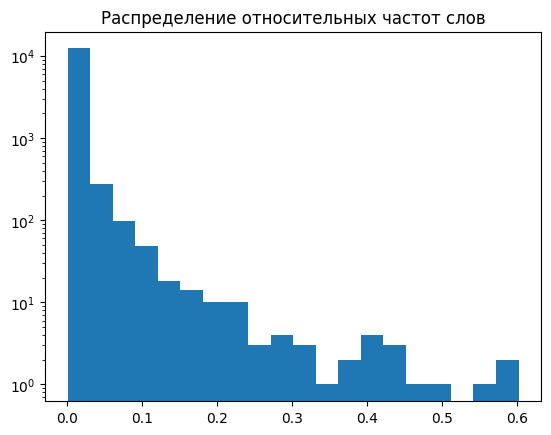

In [ ]:
# Визуализируем распределение частот слов
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log')
plt.show()

In [ ]:
# Расчет PMI
from collections import defaultdict
from math import log2

def calculate_pmi(tokenized_corpus, vocabulary):
    """Расчет точечной взаимной информации (PMI) для каждого слова в словаре."""
    word_count = defaultdict(int)
    pair_count = defaultdict(int)
    total_count = 0

    # Подсчет частоты слов и пар слов
    for tokens in tokenized_corpus:
        total_count += len(tokens)
        for token1 in tokens:
            word_count[token1] += 1
            for token2 in tokens:
                if token1 != token2:
                    pair_count[(token1, token2)] += 1

    # Вычисление PMI для каждого слова в словаре
    pmi_scores = {}
    for word in vocabulary:
        word_freq = word_count.get(word, 0)
        if word_freq > 0:
            p_word = word_freq / total_count
            # PMI для отдельных слов
            pmi = log2(p_word / ((sum(word_count[w] for w in vocabulary) / total_count)))
            pmi_scores[word] = pmi

    return pmi_scores

pmi_scores = calculate_pmi(train_tokenized, vocabulary)
print("\nПример PMI-оценок:")
print(list(pmi_scores.items())[:10])


Пример PMI-оценок:
[('this', -6.324967700116833), ('have', -6.47975388018796), ('with', -6.5408143556408165), ('writes', -7.684008267360606), ('article', -7.760683054940768), ('posting', -8.194331194401876), ('host', -8.334824325944798), ('nntp', -8.388361661078259), ('there', -7.379250029870382), ('what', -7.353863845751289)]


In [ ]:
# Векторизация текстов с использованием PMI
def vectorize_texts_with_pmi(tokenized_texts, vocabulary, pmi_scores):
    """Векторизация текстов с использованием значений PMI."""
    row, col, data = [], [], []

    for i, tokens in enumerate(tokenized_texts):
        token_counts = collections.Counter(tokens)
        for token, count in token_counts.items():
            if token in vocabulary:
                row.append(i)
                col.append(vocabulary[token])
                data.append(pmi_scores.get(token, 0) * count)

    matrix = torch.sparse_coo_tensor(
        indices=[row, col],
        values=data,
        size=(len(tokenized_texts), len(vocabulary))
    )
    return matrix

train_vectors_pmi = vectorize_texts_with_pmi(train_tokenized, vocabulary, pmi_scores)
test_vectors_pmi = vectorize_texts_with_pmi(test_tokenized, vocabulary, pmi_scores)

print('\nРазмерность матрицы признаков обучающей выборки (PMI)', train_vectors_pmi.shape)
print('Размерность матрицы признаков тестовой выборки (PMI)', test_vectors_pmi.shape)


Размерность матрицы признаков обучающей выборки (PMI) torch.Size([11314, 12855])
Размерность матрицы признаков тестовой выборки (PMI) torch.Size([7532, 12855])


In [ ]:
# Векторизация текстов (tf-idf)
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('\nРазмерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)


# Выводим статистику разреженности матрицы признаков
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))


Размерность матрицы признаков обучающей выборки (11314, 12855)
Размерность матрицы признаков тестовой выборки (7532, 12855)
Количество ненулевых элементов в обучающей выборке 1061498
Процент заполненности матрицы признаков 0.73%

Количество ненулевых элементов в тестовой выборке 683991
Процент заполненности матрицы признаков 0.71%


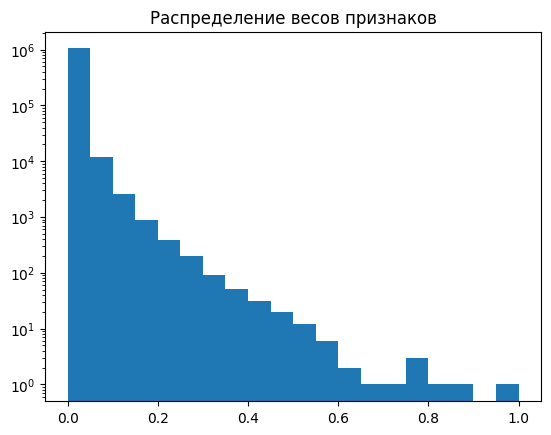

In [ ]:
# Визуализируем распределение весов признаков
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log')
plt.show()

In [ ]:
# Считаем количество уникальных меток
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


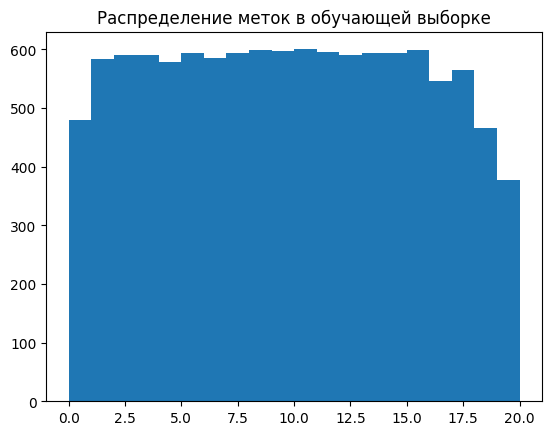

In [ ]:
# Визуализируем распределение меток
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке')
plt.show()

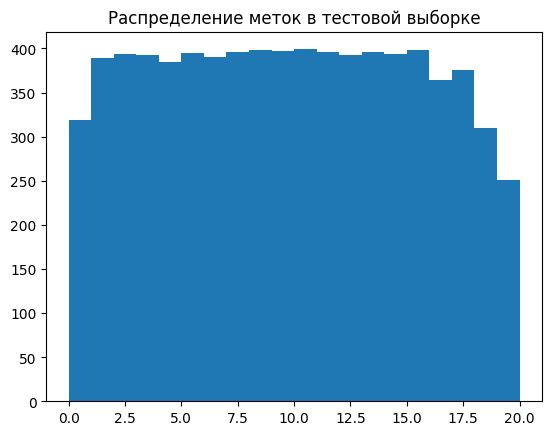

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке')
plt.show()

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [ ]:
# Трёхслойная нейронная сеть
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Создаем модель
model = ThreeLayerNN(input_dim=UNIQUE_WORDS_N, hidden_dim=32, output_dim=UNIQUE_LABELS_N)

# Определяем планировщик обучения (scheduler)
scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

# Обучаем модель с помощью train_eval_loop
result = train_eval_loop(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=1e-1,
    epoch_n=200,
    batch_size=128,
    l2_reg_alpha=1e-3,
    lr_scheduler_ctor=scheduler
)

# Если результат возвращает 2 значения (без val_losses)
if len(result) == 2:
    best_val_loss, best_model = result
    val_losses = []  # Значение по умолчанию, если список потерь не возвращён
else:
    best_val_loss, best_model, val_losses = result


Эпоха 0
Эпоха: 89 итераций, 22.72 сек
Среднее значение функции потерь на обучении 2.6482111470083174
Среднее значение функции потерь на валидации 2.3323322150666836
Новая лучшая модель!

Эпоха 1
Эпоха: 89 итераций, 21.70 сек
Среднее значение функции потерь на обучении 2.4584830289476374
Среднее значение функции потерь на валидации 2.2889568078315863
Новая лучшая модель!

Эпоха 2
Эпоха: 89 итераций, 21.10 сек
Среднее значение функции потерь на обучении 2.4438603486907615
Среднее значение функции потерь на валидации 2.3214630272428867

Эпоха 3
Эпоха: 89 итераций, 21.30 сек
Среднее значение функции потерь на обучении 2.421043610304929
Среднее значение функции потерь на валидации 2.3351162368968383

Эпоха 4
Эпоха: 89 итераций, 20.60 сек
Среднее значение функции потерь на обучении 2.4298030124621444
Среднее значение функции потерь на валидации 2.3205606007980086

Эпоха 5
Эпоха: 89 итераций, 21.80 сек
Среднее значение функции потерь на обучении 2.4370713126793335
Среднее значение функции пот

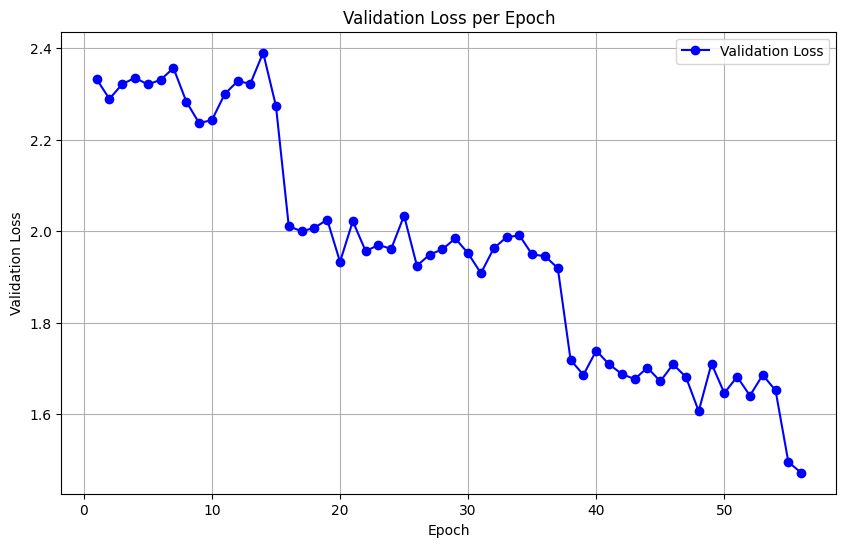

In [ ]:
val_losses = [
    2.3323322150666836, 2.2889568078315863, 2.3214630272428867, 2.3351162368968383,
    2.3205606007980086, 2.330958216877307, 2.3564874398506293, 2.283132520772643,
    2.236221707473367, 2.2427215859041376, 2.2997030928983526, 2.327651549193819,
    2.322454771753085, 2.390023251711312, 2.2731273578385176, 2.0108058715270736,
    1.9995831695653625, 2.007216873815504, 2.0250000246500566, 1.932869781882076,
    2.021681015774355, 1.9563072172261902, 1.969563817573806, 1.9614658881041964,
    2.0338087384983643, 1.9244190757557498, 1.948505462226221, 1.9603914365930073,
    1.9841186798225015, 1.951392515230987, 1.9079312672049313, 1.9624359345031996,
    1.986716973579536, 1.990742671287666, 1.948907593549308, 1.9453546313916223,
    1.919128310882439, 1.7183677402593323, 1.6856799206491244, 1.7385890039346985,
    1.7090287996550737, 1.6875794135918052, 1.6764580354852192, 1.7015922776723311,
    1.6715613199492632, 1.7087813898668451, 1.6812804108959134, 1.6062694889003948,
    1.7102879124172663, 1.64591507992502, 1.6816182378995217, 1.640320925389306,
    1.6855470871521254, 1.651812420052997, 1.4951470605397628, 1.4718054957309012
]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='b', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Оценка на обучающей выборке
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()

# Оценка на тестовой выборке
test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:29<00:00, 11.96it/s]


Среднее значение функции потерь на обучении 0.8682639002799988
Доля верных ответов 0.7633021035884745



236it [00:22, 10.31it/s]


Среднее значение функции потерь на валидации 1.4719266891479492
Доля верных ответов 0.5678438661710037
